# Projeto 2 – Avaliando a performance de modelos de predição

--------------------------------

Neste projeto continuaremos a trabalhar com o problema da companhia de cartao de créditos. As tarefas desta vez consistem em: 

+ Discutir as implicações de dados desbalanceados em classificação binária.
+ Separar os dados em conjuntos de treino e teste.
+ Implementar modelos preditivos usando o scikit-learn.
+ Criar curvas ROC e de precisao

**Atualização do cliente: -2: nao houve uso da conta; -1 pagamento em dia; 0 pagamento mínimo foi realizado.**

In [1]:
### Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Customização 
pd.options.display.max_columns = 24
pd.options.display.precision = 3

sns.set(style="ticks", context="notebook", palette='pastel')
plt.style.use("dark_background")

plt.rcParams['figure.figsize'] = (15,6)


df = pd.read_csv(r'../Projeto 1 - Exploração e eliminação de dados espúrios/base_limpa.csv')
df.head()

,ID,LIMIT_BAL,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,798fc410-45c1,20000,2,1,24,2.0,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,8a8c8f3b-8eb4,120000,2,2,26,-1.0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,85698822-43f5,90000,2,2,34,0.0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,0737c11b-be42,50000,2,1,37,0.0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,3b7f77cc-dbc0,50000,2,1,57,-1.0,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Vamos investigar primeiramente apenas o desempenho da variável EDUCATION como preditorada resposta default payment next month

----------------------

## Tipos de divisão dos dados em teste e treino

In [2]:
### Separando a feature e a target

x = df['EDUCATION']
y = df['default payment next month']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=21)

Primeiramente realizamos uma amostragem aleatória para treinar o modelo, veremos se essa amostragem foi adequada ou se devemos utilizar uma amostragem estratificada para garantir ao modelo todos os casos.

<Axes: xlabel='EDUCATION', ylabel='Count'>

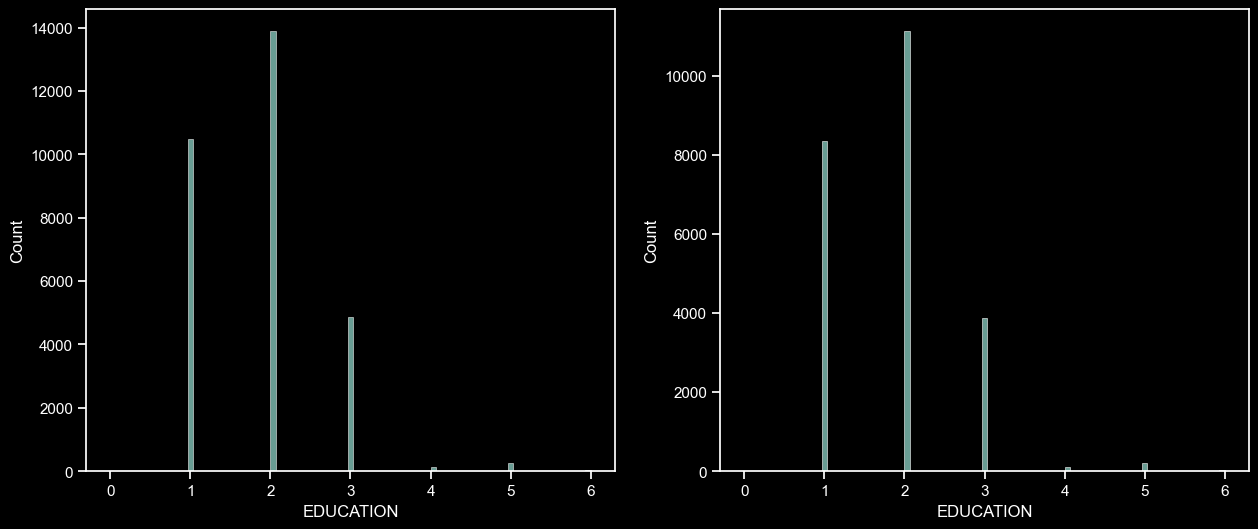

In [3]:
plt.subplot(1,2,1); sns.histplot(df['EDUCATION'])
plt.subplot(1,2,2); sns.histplot(x_train)

Aparentemente a divisão dos dados foi ok, mas vamos testar a forma estratíficada para ver a diferença.

Testando agora a separação **estratíficada**

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=21)

In [5]:
for train_index, test_index in split.split(df, df['EDUCATION']):
    train_strat = df.loc[train_index]
    test_strat = df.loc[test_index]

x_train_strat, y_train_strat = train_strat['EDUCATION'], train_strat['default payment next month']
x_test_strat, y_test_strat = test_strat['EDUCATION'], test_strat['default payment next month']

<Axes: xlabel='EDUCATION', ylabel='Count'>

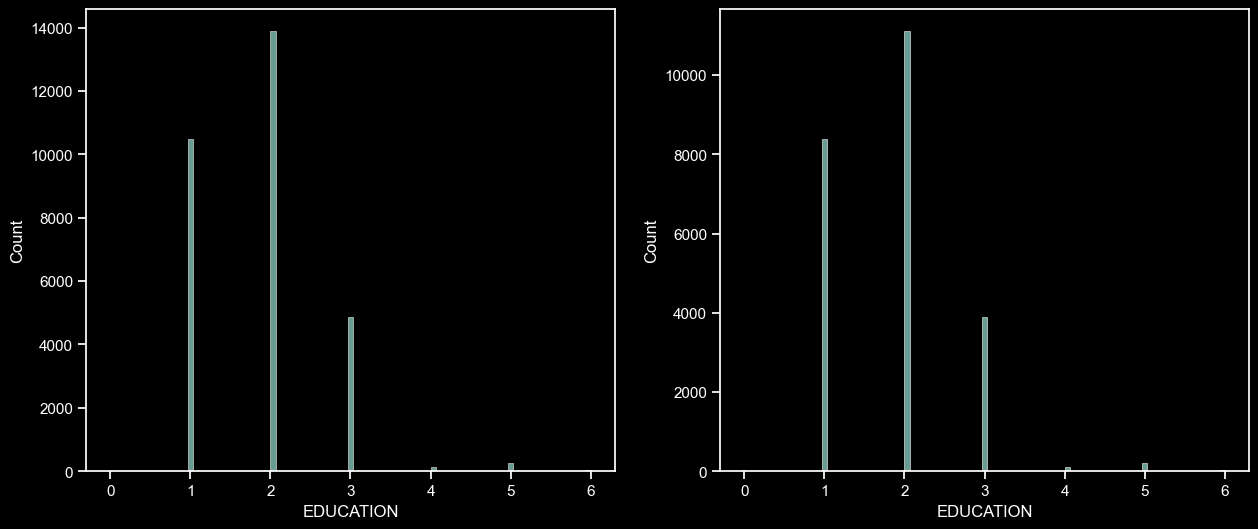

In [6]:
plt.subplot(1,2,1); sns.histplot(df['EDUCATION'])
plt.subplot(1,2,2); sns.histplot(x_train_strat)

In [7]:
### Vamos pegar as proporções do conjunto de dados como um todo, da divisão feita randomicamente e da divisão estratíficada 
todo = x.value_counts() / len(df)
train_rand = x_train.value_counts() / len(x_train)
train_strat_ = x_train_strat.value_counts() / len(x_train_strat)

### Erros de cada divisão 
err_rand = 100 * train_rand / todo - 100
err_strat = 100 * train_strat_ / todo - 100

pd.DataFrame({'Todo': todo,
             'Rand': train_rand,
             'Strt': train_strat_,
             'Erro % Rand': err_rand,
             'Erro % Strt': err_strat}, index=todo.keys()).sort_index()

,Todo,Rand,Strt,Erro % Rand,Erro % Strt
0,5.390e-04,6.737e-04,5.474e-04,25.003,1.565e+00
1,3.528e-01,3.519e-01,3.528e-01,-0.262,1.395e-04
2,4.677e-01,4.687e-01,4.677e-01,0.208,7.257e-04
3,1.639e-01,1.637e-01,1.639e-01,-0.141,-1.288e-02
4,4.110e-03,4.463e-03,4.126e-03,8.609,4.124e-01
5,9.263e-03,8.842e-03,9.264e-03,-4.543,2.526e-03
6,1.651e-03,1.768e-03,1.642e-03,7.146,-5.077e-01


Ou seja, mesmo que a divisão feita randomicamente podemos ver que a estratíficada ganha muitos pontos por exemplo quando o valor da variável education é igual a 0, 4 e 6.

## Implementando e Avaliando um modelo de Regressao Logística

In [8]:
def reshape_series(serie):
    serie = np.asarray(serie).reshape(-1,1)
    return serie

x_train_strat = reshape_series(x_train_strat)
y_train_strat = reshape_series(y_train_strat)
x_test_strat = reshape_series(x_test_strat)
y_test_strat = reshape_series(y_test_strat)

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

logreg = LogisticRegression()
logreg.fit(x_train_strat, y_train_strat.ravel())

y_pred = logreg.predict(x_train_strat)

### Acurácia do Modelo

In [10]:
acuracia = accuracy_score(y_train_strat, y_pred)

print('A acurácia do modelo de Regressão Logística foi de:', acuracia)

A acurácia do modelo de Regressão Logística foi de: 0.7807486631016043


In [11]:
df['default payment next month'].value_counts()

0    23125
1     6562
Name: default payment next month, dtype: int64

### Matriz de Confusão

In [12]:
matriz_conf = confusion_matrix(y_train_strat, y_pred)

print('Matriz de Confusão: \n', matriz_conf)

Matriz de Confusão: 
 [[18542     0]
 [ 5207     0]]


Olhando pela acurácia de 78% aparentemente o modelo apresentou um bom resultado, mas olhando pela matriz de confusão podemos ver que o modelo não previu nenhum cliente que deixou de pagar a conta.

### Stacked Histogram das probabilidades de classificação

In [13]:
predict_proba = logreg.predict_proba(x_train_strat)

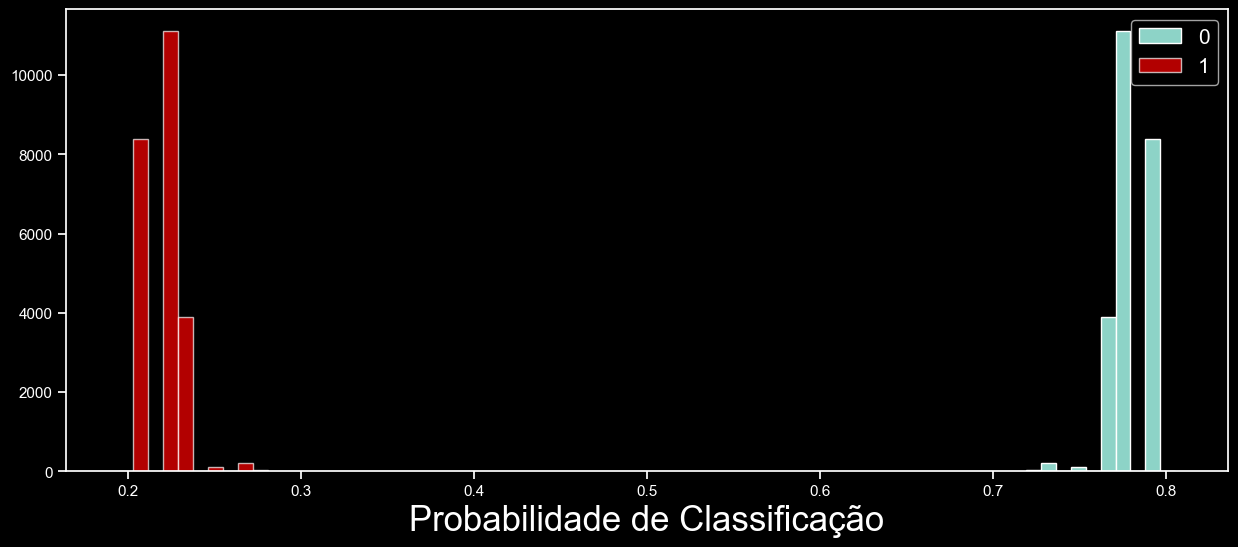

In [14]:
plt.hist(predict_proba[:, 0], label='0')
plt.hist(predict_proba[:, 1], label='1', alpha=0.7, color='red', histtype='barstacked')
plt.xlabel('Probabilidade de Classificação', fontsize=25)
#plt.ylabel('', fontsize=25)
plt.legend(fontsize=15)

O classificador ficou voltado muito mais a classificar os indivíduos como adimplentes do que inadimplentes, porém de forma viesada.

### Curva ROC

C:\Users\lagee\Documents\Workspace\Credito Bancario\venv\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


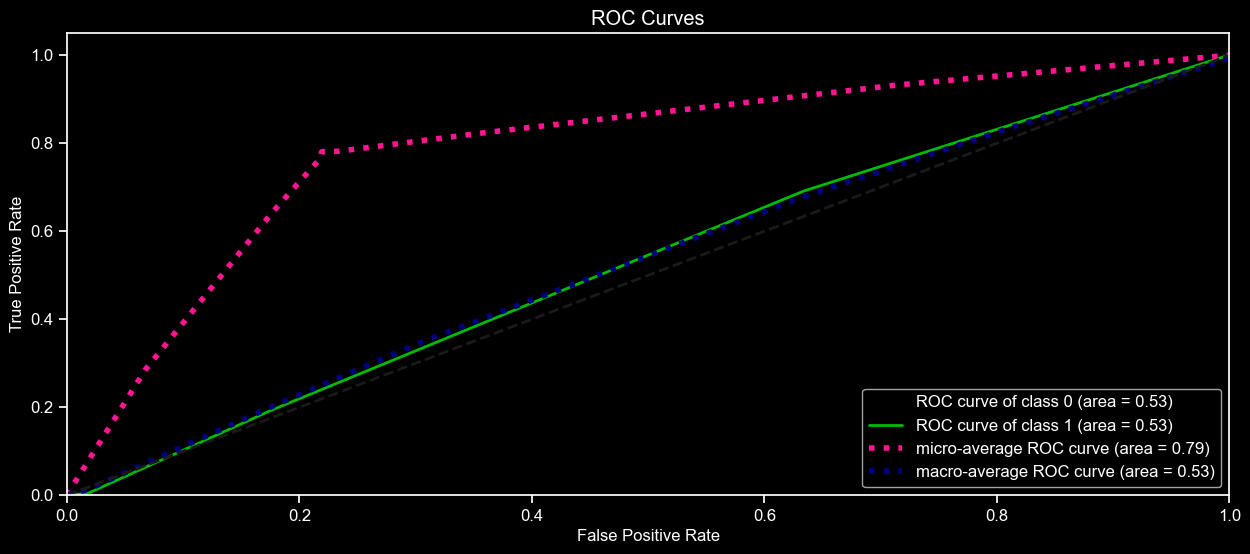

In [20]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import scikitplot as skplt

fig1 = skplt.metrics.plot_roc_curve(y_train_strat, predict_proba)
plt.show()

Podemos ver nitidamente o que aconteceu com o classificador, mesmo que a acurácia tenha sido de 78%, ele performou muito mal. Não houve previsão de nenhum inadimplente e erramos muito no negativos também. Provavelmente diminuindo o threshould o modelo ira performar melhor.

In [21]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_strat, y_pred, zero_division=1)

1.0

In [22]:
recall_score(y_train_strat, y_pred)

0.0

# Regressão utilizando desta vez a variável  LIMIT_BAL 
----------------------------




<Axes: xlabel='LIMIT_BAL', ylabel='Count'>

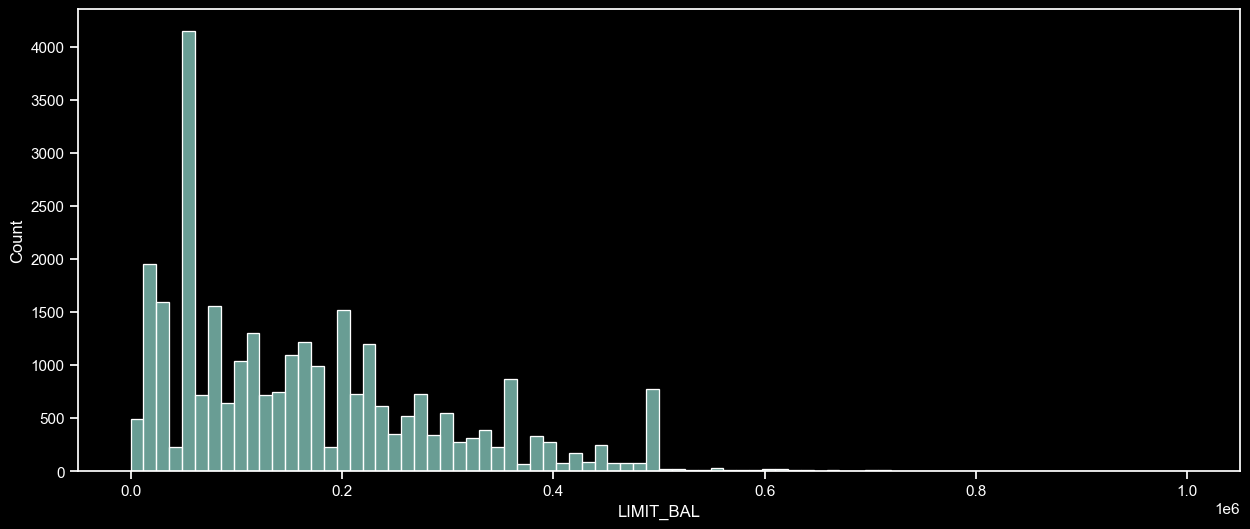

In [23]:
sns.histplot(df['LIMIT_BAL'])

In [24]:
df['LIMIT_BAL'].value_counts()

50000      3328
20000      1950
30000      1597
80000      1552
200000     1517
           ... 
16000         2
760000        1
690000        1
327680        1
1000000       1
Name: LIMIT_BAL, Length: 82, dtype: int64

Para essa variável, teremos que criar faixar para poder estratíficar as amostragens, isso porque se colocarmos a variável da forma que está, não conseguirimos dividir os valores unicos.

In [25]:
x = pd.DataFrame(df['LIMIT_BAL'])
y = df['default payment next month']

x['faixas limit bal'] = pd.cut(df["LIMIT_BAL"],
                               bins=[-1, 20000, 40000, 60000, 80000, 1000000],
                               labels=[1, 2, 3, 4, 5])

In [26]:
### Split

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=21)

for train_index, test_index in split.split(x, x['faixas limit bal']):
    train_strat2 = df.loc[train_index]
    test_strat2 = df.loc[test_index]

x_train_strat2, y_train_strat2 = train_strat2['LIMIT_BAL'], train_strat2['default payment next month']
x_test_strat2, y_test_strat2 = test_strat2['LIMIT_BAL'], test_strat2['default payment next month']

## Aplicando o Modelo de Regressão Logística

In [27]:
## Implementando e Avaliando um modelo de Regressao Logística

def reshape_series(serie):
    serie = np.asarray(serie).reshape(-1,1)
    return serie

x_train_strat2 = reshape_series(x_train_strat2)
y_train_strat2 = reshape_series(y_train_strat2)
x_test_strat2 = reshape_series(x_test_strat2)
y_test_strat2 = reshape_series(y_test_strat2)

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix

logreg2 = LogisticRegression()
logreg2.fit(x_train_strat2, y_train_strat2.ravel())

y_pred2 = logreg.predict(x_train_strat2)

## Métricas

In [28]:
### Acurácia do Modelo

acuracia = accuracy_score(y_train_strat2, y_pred2)

print('A acurácia do modelo de Regressão Logística foi de:', acuracia)

A acurácia do modelo de Regressão Logística foi de: 0.22261989978525412


In [29]:
confusion_matrix(y_train_strat2, y_pred2)

array([[    1, 18462],
       [    0,  5286]], dtype=int64)

### ROC

In [30]:
predict_proba2 = logreg.predict_proba(x_train_strat2)
#predict_proba2

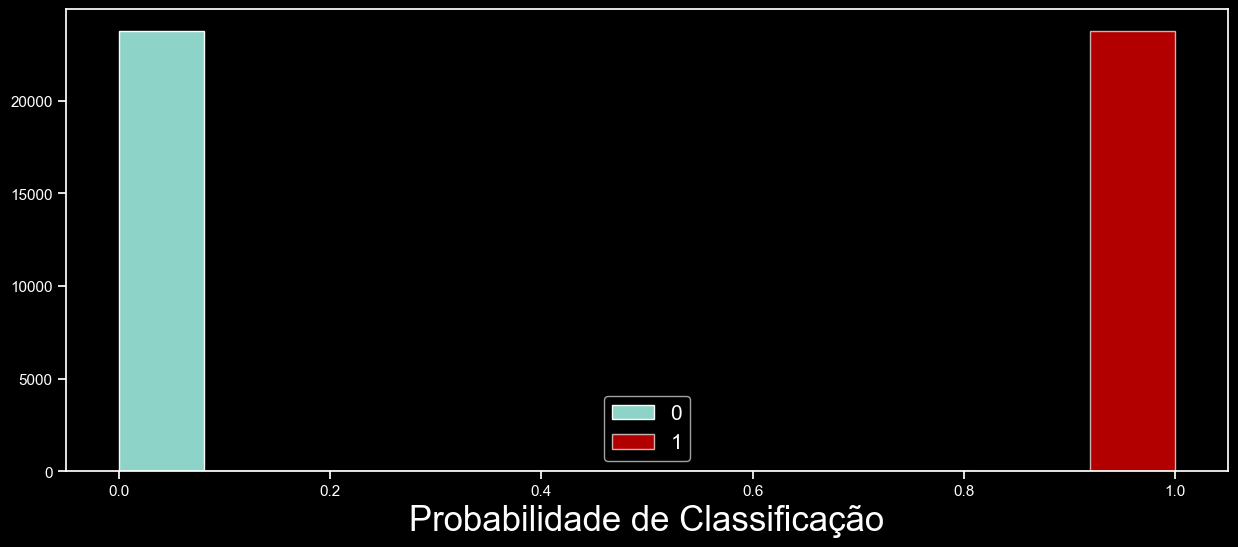

In [31]:
plt.hist(predict_proba2[:, 0], label='0')
plt.hist(predict_proba2[:, 1], label='1', alpha=0.7, color='red', histtype='barstacked')
plt.xlabel('Probabilidade de Classificação', fontsize=25)
plt.legend(fontsize=15)

C:\Users\lagee\Documents\Workspace\Credito Bancario\venv\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lagee\Documents\Workspace\Credito Bancario\venv\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


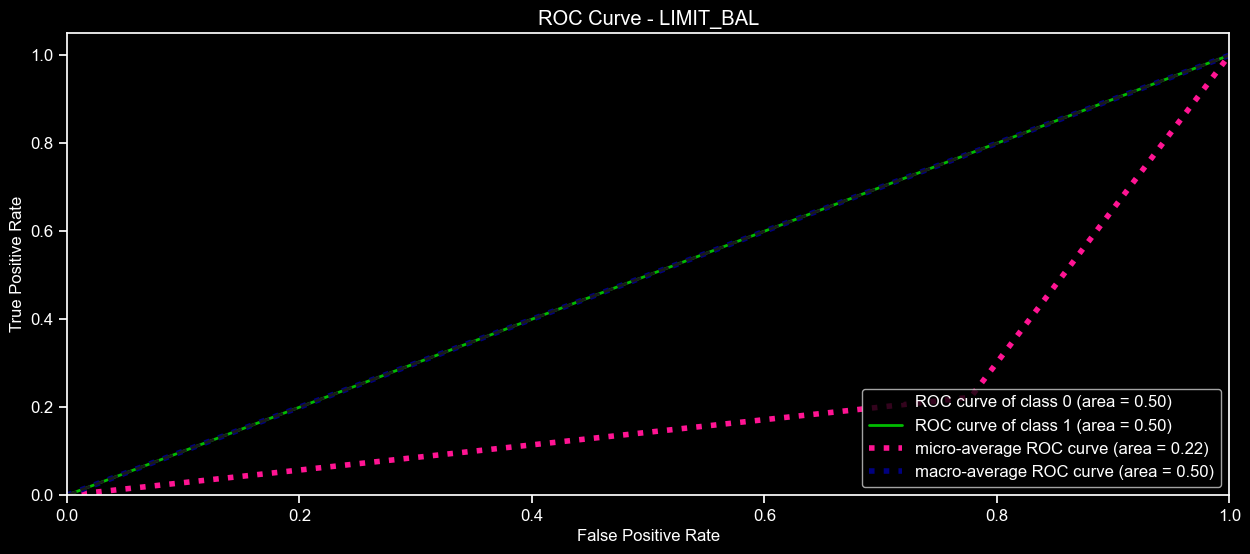

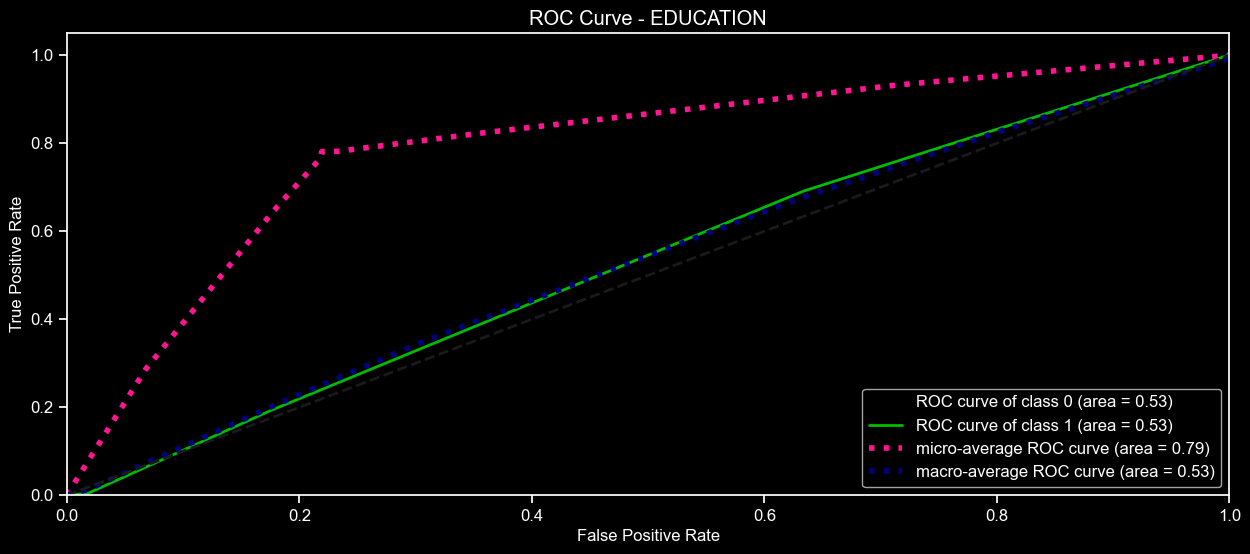

In [32]:
### Comparando curvas ROCs das variáveis EDUCATION & LIMIT_BALL

fig2 = skplt.metrics.plot_roc_curve(y_train_strat2, predict_proba2, title='ROC Curve - LIMIT_BAL')
fig1 = skplt.metrics.plot_roc_curve(y_train_strat, predict_proba, title='ROC Curve - EDUCATION')

plt.show()

Utilizando a variável LIMIT_BAL como variável explicativa, podemos ver um maior equilíbrio das probabilidades e as curvas mais abauladas, entretanto o modelo ainda sim ficou inviesado para classificar os clientes como adimplentes, podemos ver pela matriz de confusão que mesmo mudando a variável não tivemos classificação de inadimplentes.

### Precision x Recall

In [33]:
predict_proba2_test = logreg.predict_proba(x_test_strat2)

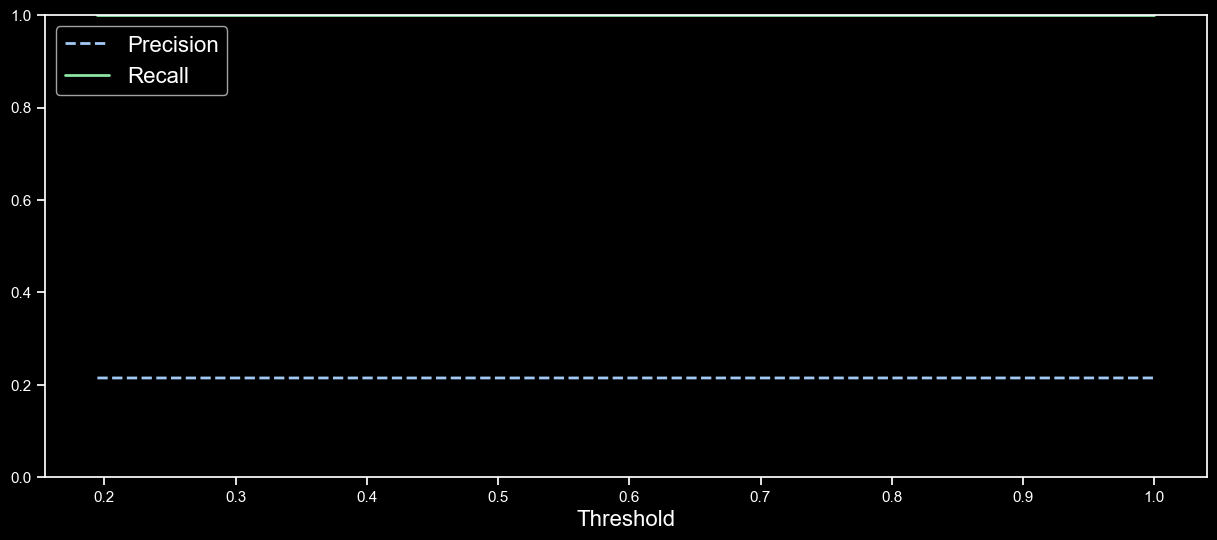

In [34]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_test_strat2, predict_proba2_test[:, 1])
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

In [35]:
from sklearn.metrics import precision_score, recall_score

y_pred2_test = logreg.predict(x_test_strat2)

print('Precision Score:', precision_score(y_test_strat2, y_pred2_test, zero_division=1))
print('Recall Score:', recall_score(y_test_strat2, y_pred2_test, zero_division=1))

Precision Score: 0.21492336196732356
Recall Score: 1.0


## ROC Treino x ROC Teste

C:\Users\lagee\Documents\Workspace\Credito Bancario\venv\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\lagee\Documents\Workspace\Credito Bancario\venv\Lib\site-packages\sklearn\utils\deprecation.py:86: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.5.0. Please use scikitplot.metrics.plot_roc instead.
  warnings.warn(msg, category=FutureWarning)


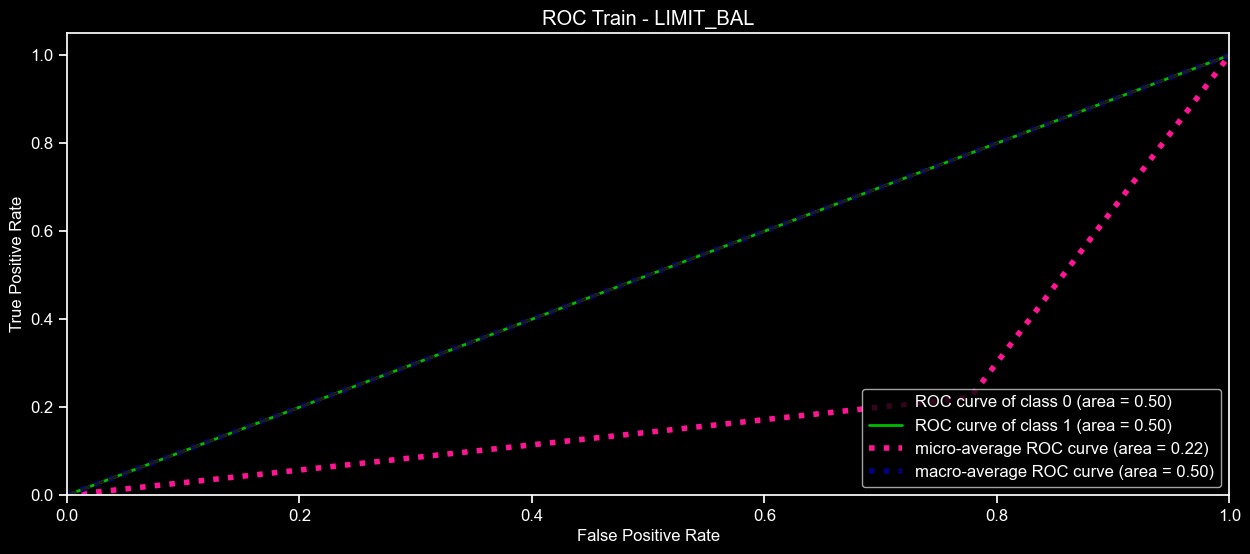

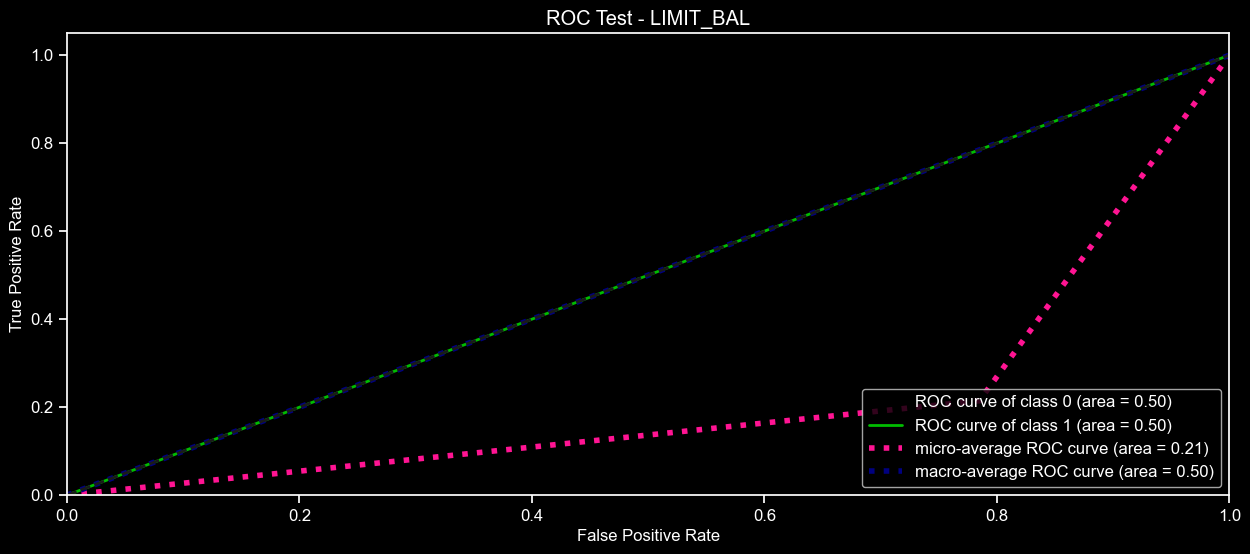

In [36]:
fig2 = skplt.metrics.plot_roc_curve(y_train_strat2, predict_proba2, title='ROC Train - LIMIT_BAL')
fig3 = skplt.metrics.plot_roc_curve(y_test_strat2, predict_proba2_test, title='ROC Test - LIMIT_BAL')

plt.show()

Podemos ver que a diferença entre a curva ROC de treino e curva ROC de teste apresentaram resultados muito semelhantes.
O modelo não conseguiu generalizar bem sobre nenhum dos dados apresentados.

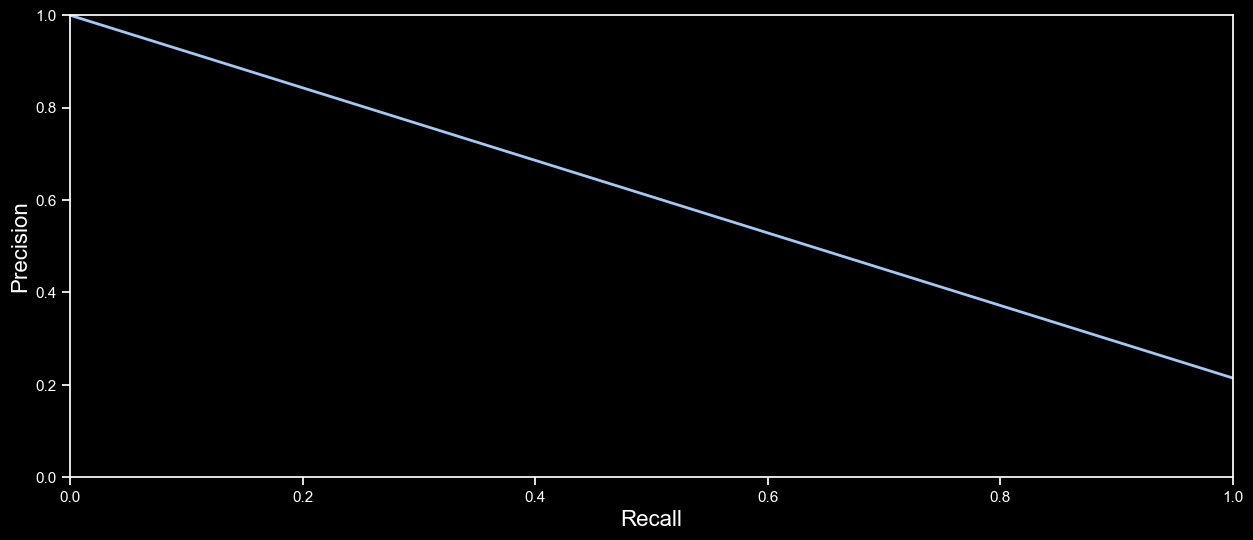

In [37]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plot_precision_vs_recall(precisions, recalls)